In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib import gridspec

# Galerkin method for dipole problem

In [2]:
def galerkin_dipole(x,y,L,rc,d,density,mMax):
    '''Function for solution to dipole problem with Galerkin method at selected x,y'''

    phiA=0.
    for m in range(mMax):
        for n in range(mMax):
            phiA+=a_m_n(m,n,L,rc,d,density)*(np.cos(m*np.pi*x/L)*np.cos(n*np.pi*y/L))
                
    return phiA

def a_m_n(m,n,L,rc,d,density):
    '''Function for prefactor of Galerkin solution to dipole'''
    
    rPlus=rc+0.5*d
    rMinus=rc-0.5*d
    eps0=8.8541878128e-12 # C^2/Jm
    
    coeff=4./(np.pi**2*eps0)
              
    if m!=0 or n!=0: coeff*=1./(m**2+n**2)
    if m==0: coeff*=0.5
    if n==0: coeff*=0.5
        
    # Note that integral of delta functions results in lambda[f_mn(r+)-f_mn(r-)]
    amn=coeff*density*(np.cos(m*np.pi*rPlus[0]/L)*np.cos(n*np.pi*rPlus[1]/L)- \
                  np.cos(m*np.pi*rMinus[0]/L)*np.cos(n*np.pi*rMinus[1]/L))
    
    return amn
    

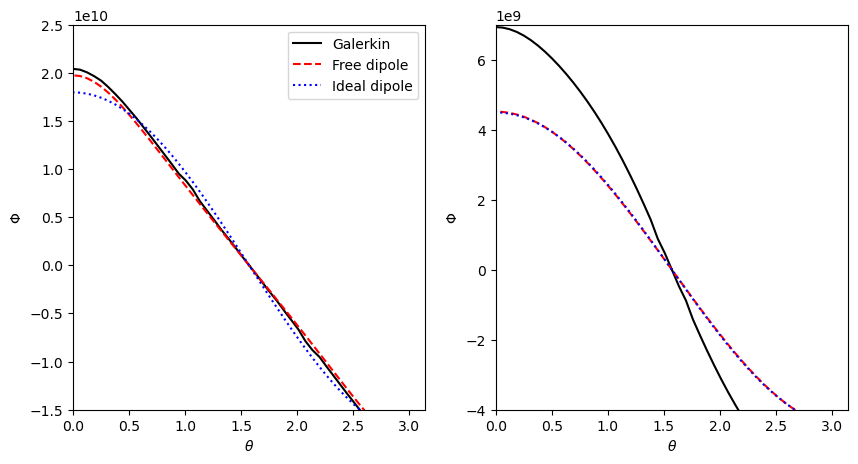

In [3]:
# Paramters
mMax=100
N=100
L=1.
density=1.
rc=np.array([0.5,0.5])
d=np.array([0.,0.1])
eps0=8.8541878128e-12 # C^2/Jm

# Plot:
fig1,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

# Generate points on circle with r=0.1 
ang=[]
x=[]
y=[]
r=0.1
for pt in range(N+1):
    xpt=np.cos(2*np.pi/N*pt)*r
    ypt=np.sin(2*np.pi/N*pt)*r
    ang.append(np.arctan2(xpt,ypt))
    x.append(xpt+rc[0])
    y.append(ypt+rc[1])

x=np.array(x)
y=np.array(y)

# Need these for free dipole calculation
rPlus=rc+0.5*d
rMinus=rc-0.5*d
delMinus=np.array([x-rMinus[0],y-rMinus[1]])
delPlus=np.array([x-rPlus[0],y-rPlus[1]])

phiA=galerkin_dipole(x,y,L,rc,d,density,mMax)
phiFree=(-density/(2*np.pi*eps0))*(np.log(np.linalg.norm(delPlus,axis=0)) \
                   -np.log(np.linalg.norm(delMinus,axis=0)))
phiIdeal=(density/(2*np.pi*eps0))*(np.linalg.norm(d)/(r*L))*np.cos(np.array(ang))

#Plot
ax1.plot(ang,phiA,'k-',label='Galerkin')
ax1.plot(ang,phiFree,'r--',label='Free dipole')
ax1.plot(ang,phiIdeal,'b:',label='Ideal dipole')
ax1.set_xlim(0,np.pi)
ax1.set_xlim(0,np.pi)
ax1.set_ylim(-1.5e10,2.5e10)
ax1.set_xlabel(r'$\theta$')
ax1.set_ylabel(r'$\Phi$')
ax1.legend()

# Generate points on circle with r=0.4 
ang=[]
x=[]
y=[]
r=0.4
for pt in range(N+1):
    xpt=np.cos(2*np.pi/N*pt)*r
    ypt=np.sin(2*np.pi/N*pt)*r
    ang.append(np.arctan2(xpt,ypt))
    x.append(xpt+rc[0])
    y.append(ypt+rc[1])

x=np.array(x)
y=np.array(y)
delMinus=np.array([x-rMinus[0],y-rMinus[1]])
delPlus=np.array([x-rPlus[0],y-rPlus[1]])

# Solved using the Galerkin method
phiA=galerkin_dipole(x,y,L,rc,d,density,mMax)

# Potential of free dipole
phiFree=(-density/(2*np.pi*eps0))*(np.log(np.linalg.norm(delPlus,axis=0)) \
                   -np.log(np.linalg.norm(delMinus,axis=0)))

# Potential for ideal dipole
phiIdeal=(density/(2*np.pi*eps0))*(np.linalg.norm(d)/(r*L))*np.cos(np.array(ang))

#Plot
ax2.plot(ang,phiA,'k-',label='Galerkin')
ax2.plot(ang,phiFree,'r--',label='Free dipole')
ax2.plot(ang,phiIdeal,'b:',label='Ideal dipole')
ax2.set_xlim(0,np.pi)
ax2.set_ylim(-4e9,7e9)
ax2.set_xlabel(r'$\theta$')
ax2.set_ylabel(r'$\Phi$')

plt.savefig('galerkin_dipole.pdf',bbox_inches='tight')

plt.show()

# Multiple Fourier transform method for dipole problem

In [ ]:
def mft_dipole(N,L,rho):
    '''Function to use the multiple Fourier transform method for the dipole problem'''
    
    eps0=8.8541878128e-12 # C^2/Jm
    tol=1e-15 # Small number to avoid division by zero in Pmn
    
    # Assume square grid
    h=L/N
    nlin=np.linspace(0,N-1,N)
    mlin=np.linspace(0,N-1,N)    
    n,m=np.meshgrid(nlin,mlin)
    
    Rmn=np.fft.fft2(rho)
    Pmn=(-h**2/(2.*eps0))/(np.cos(2.*np.pi*m/N)+np.cos(2.*np.pi*n/N)-2+tol)
    
    Fmn=Pmn * Rmn
    phi=np.fft.ifft2(Fmn)
    
    return phi.real
    
def rho_dipole(N,L,rc,d,density):
    '''Setup the density of a dipole line'''
    
    rho=np.zeros((N,N))
    
    h=L/N
    rPlus=(rc+0.5*d)/h
    rMinus=(rc-0.5*d)/h
    
    rho[int(rPlus[0]),int(rPlus[1])]=density/h**2
    rho[int(rMinus[0]),int(rMinus[1])]=-density/h**2
    
    return rho
    

In [ ]:
# Paramters
N=40
L=1.
density=1.
rc=np.array([0.5,0.5])
d=np.array([0.,0.1])
mycmap=cm.plasma

xlin=np.linspace(0,L,N)
ylin=np.linspace(0,L,N)
x,y=np.meshgrid(xlin,ylin)

rho=rho_dipole(N,L,rc,d,density)
phi=mft_dipole(N,L,rho)

# Plots
fig = plt.figure(figsize=(30,8))
ax0 = fig.add_subplot(1, 3, 1, projection='3d')
ax1 = fig.add_subplot(1, 3, 2,)
ax2 = fig.add_subplot(1, 3, 3,)

# 3D plot:
ax0.plot_surface(x,y,phi,cmap=mycmap)
#ax0.plot_surface(x,y,rho,cmap=mycmap)
# Contour plot:
CS_gs=ax1.contour(x,y,phi)
ax1.clabel(CS_gs)
# E field (normalized to 1 so it is easier to see:
[Ex,Ey]=np.gradient(phi)
Ex/=-np.sqrt(Ex**2+Ey**2)
Ey/=-np.sqrt(Ex**2+Ey**2)
ax2.quiver(x,y,Ex,Ey)

# Label axes
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax0.set_zlabel(r'$\Phi$')

ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_xlabel('x')
ax2.set_ylabel('y')

plt.savefig('mft_dipol.pdf',bbox_inches='tight')
plt.show()
